In [6]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 29.5 MB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 684 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 76.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:

def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            current_path = current_path.replace('\\', '/')
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())
root

'/Users/carinamanitius/Documents/GitHub/climate_migration'

# Download, analyze, create categories

In [8]:
df1 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_1.parquet")
df2 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_2.parquet")
df3 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_3.parquet")
df4 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_4.parquet")

df = pd.concat([df1, df2, df3, df4])
df['State FIPS'] = df['State FIPS'].apply(lambda x: f"{int(x):02d}")
df['County/Zone FIPS'] = df['County/Zone FIPS'].apply(lambda x: f"{int(x):03d}")
df['FIPS'] = df['State FIPS'] + df['County/Zone FIPS']
df = df[df['Year'] >= 2000]

In [9]:
df['Property Damage'].value_counts()
def convert_to_number(value):
    if pd.isna(value):
        return 0
    value = value.strip().lower()
    if value == 'k':
        return 1000
    elif value.endswith('k'):
        return int(float(value[:-1]) * 1000)
    elif value.endswith('m'):
        return int(float(value[:-1]) * 1000000)
    elif value.endswith('h'):
        return int(float(value[:-1]) * 100)
    elif value.endswith('b'):
        return int(float(value[:-1]) * 1000000000)
    else:
        return 0
    

def fk_log10(num):
    if num == 0: return 0
    else: return np.log10(num)
    

In [10]:
df['property_num'] = df['Property Damage'].map(lambda x : convert_to_number(x))
df['property_num'].value_counts()
df['property_log'] = df['property_num'].map(lambda x: fk_log10(x))

In [11]:
df.columns

Index(['OBJECTID', 'State', 'Month', 'Event Type', 'Begin Date Time',
       'Property Damage', 'Begin Lat', 'Begin Lon', 'Episode Narrative',
       'Event Narrative', 'Lat/Lon Known', 'State FIPS', 'Year',
       'County/Zone FIPS', 'County/Zone Type', 'Event ID', 'Direct Injuries',
       'Indirect Injuries', 'Indirect Deaths', 'Direct Deaths', 'Episode ID',
       'Source', 'Data Source', 'Tornado F Scale', 'County/Zone Name',
       'Total Injuries and Deaths', 'x', 'y', 'FIPS', 'property_num',
       'property_log'],
      dtype='object')

In [12]:
df['deaths'] = df['Direct Deaths'] + df['Indirect Deaths']
df['injuries'] = df['Direct Injuries'] + df['Indirect Injuries']

In [14]:
a = df['injuries'].value_counts()
a = a.reset_index()
a = a.sort_values(by='injuries', ascending=False)
a.head(50)

,injuries,count
127,2400,1
97,1150,1
90,800,1
74,700,2
126,519,1
95,500,1
106,468,1
85,450,1
118,437,1
125,422,1


<Axes: xlabel='property_log', ylabel='Count'>

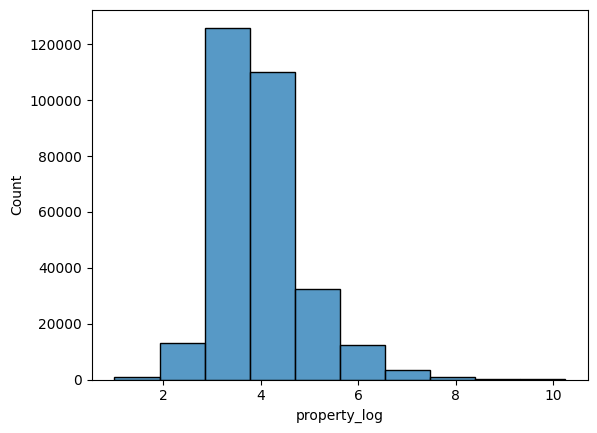

In [15]:
sns.histplot(data=df[df['property_log']>0], x='property_log', bins=10)

<Axes: xlabel='deaths'>

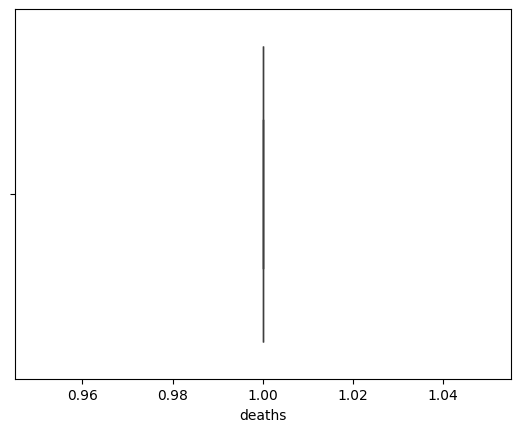

In [16]:
sns.boxplot(data=df[df['deaths']>0], x='deaths', showfliers=False)

In [17]:
df.sort_values(by='deaths', ascending=False, inplace=True)
df[['deaths', "Indirect Deaths", "Direct Deaths"]]

,deaths,Indirect Deaths,Direct Deaths
687675,638,0,638
1084469,161,3,158
687699,140,0,140
686823,97,0,97
1677740,87,0,87
...,...,...,...
851023,0,0,0
851022,0,0,0
851021,0,0,0
851020,0,0,0


<Axes: xlabel='deaths_log', ylabel='Count'>

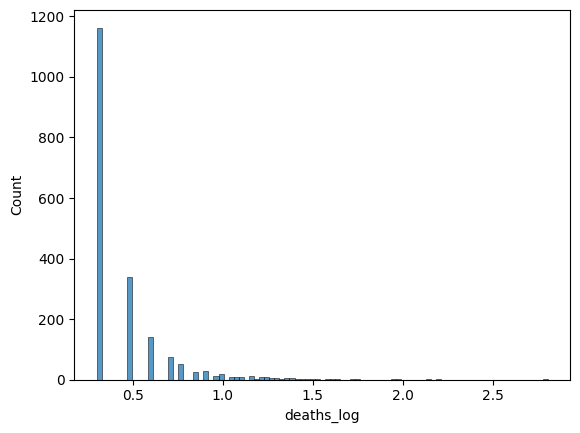

In [18]:
df['deaths_log'] = df['deaths'].apply(lambda x : fk_log10(x))
sns.histplot(data=df[df['deaths_log'] >0], x='deaths_log')

## Classic power law!

## create categories and save

In [19]:
def property_cater(plog):
    if plog <= 2: 
        return 1
    elif plog <= 4:
        return 2
    elif plog <= 5:
        return 3
    elif plog <= 7:
        return 4
    elif plog <= 9:
        return 5
    else:
        return 6

def death_cater(count):
    if count == 0:
        return 1
    elif count <= 1:
        return 2
    elif count <= 10:
        return 3
    elif count <= 50:
        return 4
    elif count <= 100:
        return 5
    else:
        return 6
    

In [20]:
df['injury_cat'] = df['injuries'].apply( ## note injury data is pretty wonky but we put it in there just in case; will probably remove later.
    lambda x : death_cater(x))
df['death_cat'] = df['deaths'].apply(
    lambda x: death_cater(x))
df['property_cat'] = df['property_log'].apply(
    lambda x: property_cater(x))

In [21]:
# Determine the size of each split
split_size = len(df) // 4

# Split and save each part as a Parquet file
# for i in range(4):
#     start_index = i * split_size
#     # Handle the last chunk to include any remaining rows
#     end_index = None if i == 3 else (i + 1) * split_size
#     df_part = df.iloc[start_index:end_index]
#     df_part.to_parquet(
#         f'{root}/Data/Storm events/Cleaned/cleaned_stormevents_{i+1}.parquet', engine='pyarrow', index=False
#         )
    
df['property_cat'].value_counts()
    

property_cat
1    991908
2    179308
3     85407
4     30122
5      2079
6        68
Name: count, dtype: int64

# Summarize, Periodize, and Merge Data

## for all the storm events data

In [31]:
df['STATE_FIPS'] = df['State FIPS']
df['COUNTY_FIPS'] = df['County/Zone FIPS']
events_trimmed = df[[
   'State',  'Event Type', 'Begin Date Time', 'STATE_FIPS', 'COUNTY_FIPS',
       'Property Damage', 'Begin Lat', 'Begin Lon', 'Lat/Lon Known', 'Year', 'Event ID', 'Episode ID', 'County/Zone Name',
       'Total Injuries and Deaths', 'x', 'y', 'FIPS', 'injury_cat',
       'death_cat', 'property_cat'
]]
df1 = events_trimmed.copy()
# Create counts for each category
result_death = pd.crosstab(index=[df1['Year'], df1['STATE_FIPS'], df1['COUNTY_FIPS']], columns=df1['death_cat'])
result_property = pd.crosstab(index=[df1['Year'], df1['STATE_FIPS'], df1['COUNTY_FIPS']], columns=df1['property_cat'])

# Merge the two results into one working DataFrame
table_form_events = result_death.merge(result_property, on=['Year', 'STATE_FIPS', 'COUNTY_FIPS'], suffixes=('_death', '_property'))

table_form_events.reset_index(inplace=True)

table_form_events.to_csv(f"{root}/Data/Storm events/FINAL.csv")

table_form_events


,Year,STATE_FIPS,COUNTY_FIPS,1_death,2_death,3_death,4_death,5_death,6_death,1_property,2_property,3_property,4_property,5_property,6_property
0,2000,01,001,19,0,0,0,0,0,6,10,2,1,0,0
1,2000,01,002,2,1,0,0,0,0,0,2,1,0,0,0
2,2000,01,003,28,0,0,0,0,0,12,13,1,2,0,0
3,2000,01,004,1,0,0,0,0,0,0,0,1,0,0,0
4,2000,01,005,4,0,0,0,0,0,1,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107991,2021,99,135,1,0,0,0,0,0,0,1,0,0,0,0
107992,2021,99,137,8,0,0,0,0,0,8,0,0,0,0,0
107993,2021,99,139,5,0,0,0,0,0,4,1,0,0,0,0
107994,2021,99,141,10,0,0,0,0,0,7,3,0,0,0,0


## acs / census data

In [23]:
soc_df = pd.read_csv(
    f"{root}/Data/Census/5_year_summary.csv",
    dtype= {
        'county': str,
        'state': str
    })
soc_df['STATE_FIPS'] = soc_df['state']
soc_df['COUNTY_FIPS'] = soc_df['county']
soc_df.drop(columns=[
    'Unnamed: 0',
    "state",
    "county"
    ],
    inplace=True)
soc_df.head()

,NAME,median_household_income,start_year,end_year,median_age,median_house_value_USD,median_rent,per_pop_edu_less_than_high_school,per_pop_edu_high_school_grad,per_pop_edu_some_college,...,rental_units_35_40_per_income_per_pop,rental_units_40_50_per_income_per_pop,rental_units_above_50_per_income_per_pop,per_homes_renter_occupied,per_homes_vaccant_by_homes,per_homes_family,per_homes_without_plumbing,per_homes_without_kitchen,STATE_FIPS,COUNTY_FIPS
0,"Abbeville County, South Carolina",33143,2006,2010,41,85900.0,539,0.156144,0.228288,0.186133,...,0.005772,0.008072,0.023086,0.184912,0.182262,0.676354,0.008447,0.005797,45,001
1,"Abbeville County, South Carolina",34670,2007,2011,41,89100.0,557,0.153400,0.228728,0.195336,...,0.005017,0.007956,0.022771,0.179854,0.187966,0.684538,0.004718,0.006952,45,001
2,"Abbeville County, South Carolina",35067,2008,2012,42,90300.0,593,0.164179,0.219325,0.206641,...,0.004333,0.005987,0.021389,0.182579,0.181336,0.676959,0.004475,0.006962,45,001
3,"Abbeville County, South Carolina",35947,2009,2013,42,91200.0,629,0.156343,0.225023,0.209646,...,0.005984,0.006896,0.023184,0.192701,0.184554,0.674992,0.001330,0.002993,45,001
4,"Abbeville County, South Carolina",35409,2010,2014,43,89000.0,583,0.151235,0.242869,0.201873,...,0.005139,0.005100,0.026972,0.176876,0.189427,0.683757,0.001496,0.002410,45,001


## The plan / periodization

* One dataset per 5 year time period 
* One FIPS code per row
* Chronic variable
* Average of socio-economic drivers across period
* Acute
* Categories of property damage
* Categories of deaths (low impact, high impact, etc)
* For different time periods before the time period (since 2000, 3 years prior, 5 years prior, 10 years prior) 

In [29]:


periods = {}

num_periods = [(i, i+4) for i in range(2005, 2017)]
str_periods = [(str(i), str(i+4)) for i in range(2005, 2017)]

period_ranges_exclusive = [] 
period_ranges_inclusive = []

for period in num_periods:
    year = period[0]
    floor_2k = (2000, year)
    floor_3 =  (max(year - 3, 2000), year)
    floor_5=  (max(year - 5, 2000), year)
    floor_10= (max(year - 10, 2000), year)
    period_ranges_exclusive.append((floor_2k, floor_3, floor_5, floor_10))


    end_year = period[1]
    floor_2k = (2000, end_year)
    floor_3 =  (max(year - 3, 2000), end_year)
    floor_5=  (max(year - 5, 2000), end_year)
    floor_10= (max(year - 10, 2000), end_year)
    period_ranges_inclusive.append((floor_2k, floor_3, floor_5, floor_10))
    print(num_periods)

[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), (2016, 2020)]
[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), (2016, 2020)]
[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), (2016, 2020)]
[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), (2016, 2020)]
[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), (2016, 2020)]
[(2005, 2009), (2006, 2010), (2007, 2011), (2008, 2012), (2009, 2013), (2010, 2014), (2011, 2015), (2012, 2016), (2013, 2017), (2014, 2018), (2015, 2019), 

In [25]:
table_form_events.reset_index().head()

,index,Year,STATE_FIPS,COUNTY_FIPS,1_death,2_death,3_death,4_death,5_death,6_death,1_property,2_property,3_property,4_property,5_property,6_property
0,0,2000,01,001,19,0,0,0,0,0,6,10,2,1,0,0
1,1,2000,01,002,2,1,0,0,0,0,0,2,1,0,0,0
2,2,2000,01,003,28,0,0,0,0,0,12,13,1,2,0,0
3,3,2000,01,004,1,0,0,0,0,0,0,0,1,0,0,0
4,4,2000,01,005,4,0,0,0,0,0,1,1,2,0,0,0


In [26]:
death_cols = [f'{i}_death' for i in range(1, 7)]
property_cols = [f'{i}_property' for i in range(1, 7)]

for i, (start, end) in enumerate(str_periods):
    print("start, end", start, end)
    inputpath = f"{root}/Data/County/Summed_clean/summed_{start}_{end}.csv"
    folder = "/Data/County/County_sum_with_StormEvents"
    county_data = pd.read_csv(inputpath, dtype={
        "STATE_FIPS" : "str",
        "COUNTY_FIPS" :  "str"
    })

    def period_namer(i):
        if i == 0: return("From_2000")
        elif i == 1: return("Minus_3")
        elif i == 2: return("Minus_5")
        elif i == 3: return("Minus_10")
        else:
            raise("too many periods in period, bro")
        

    def group_period(df):
        result = (
        df.groupby(['STATE_FIPS', 'COUNTY_FIPS'])
        .agg(
            Population=('Population', 'mean'),
            Inflow_pc=('Inflow_pc', 'mean'),
            Inflow_gross=('Inflow_gross', 'mean'),
            Outflow_pc=('Outflow_pc', 'mean'),
            Outflow_gross=('Outflow_gross', 'mean'),
            **{f'Total_{col}': (col, 'sum') for col in death_cols + property_cols}
        )
        .reset_index()
        )
        return result


    #create data frames for all the sub-versions
    for x, (period_begin, period_end) in enumerate(period_ranges_exclusive[i]):
        # print("\n")
        subfolder = period_namer(x)
        # print(x, period_begin, period_end)
        # print(int(start)-4, int(start))
        
        soc_df_time = soc_df[(soc_df['start_year'] == int(start)) & (soc_df['end_year'] == int(end))].copy()
        # print(soc_df_time[['start_year', 'end_year']].head())

        time_span_merged = pd.merge(
            county_data,
            table_form_events[table_form_events['Year'].isin(range(period_begin, period_end+1))],
            on=['STATE_FIPS', 'COUNTY_FIPS']
        )
        time_span_merged = group_period(time_span_merged)
        time_span_merged = pd.merge(
            left=time_span_merged,
            right=soc_df_time,
            on=['STATE_FIPS', 'COUNTY_FIPS'],
            how='left'
        )
        print(time_span_merged.head())
        save_path = f"{root}{folder}/exclusive/{subfolder}/exclusive_merge_countysum_storm_{period_begin}_{period_end}.csv"
        time_span_merged.to_csv(save_path, index=False)

    for x, (period_begin, period_end) in enumerate(period_ranges_inclusive[i]):
        subfolder = period_namer(x)
        soc_df_time = soc_df[(soc_df['start_year'] == int(start)) 
                             & (soc_df['end_year'] == int(end))].copy()
        
        time_span_merged = pd.merge(
            county_data,
            table_form_events[table_form_events['Year'].isin(range(period_begin, period_end+1))],
            on=['STATE_FIPS', 'COUNTY_FIPS']
        )
        time_span_merged = group_period(time_span_merged)
        time_span_merged = pd.merge(
            left=time_span_merged,
            right=soc_df_time,
            on=['STATE_FIPS', 'COUNTY_FIPS'],
            how='left'
        )
        save_path = f"{root}{folder}/inclusive/{subfolder}/inclusive_merge_countysum_storm_{period_begin}_{period_end}.csv"
        time_span_merged.to_csv(save_path, index=False)

start, end 2005 2009
  STATE_FIPS COUNTY_FIPS  Population  Inflow_pc  Inflow_gross  Outflow_pc  \
0         01         001   4056791.0   0.090244        3661.0    0.107884   
1         01         003  32115069.0   0.043104       13843.0    0.029710   
2         01         005   2136783.0   0.129353        2764.0    0.163789   
3         01         007    637050.0   0.243152        1549.0    0.229183   
4         01         009   2525085.0   0.132669        3350.0    0.100069   

   Outflow_gross  Total_1_death  Total_2_death  Total_3_death  ...  \
0         3127.0             92              0              0  ...   
1         8773.0            143              6              1  ...   
2         2416.0             59              1              0  ...   
3         1878.0             52              0              0  ...   
4         2488.0             85              1              0  ...   

   rental_units_25_30_per_income_per_pop  \
0                                    NaN   
1      